# Plots of different zones

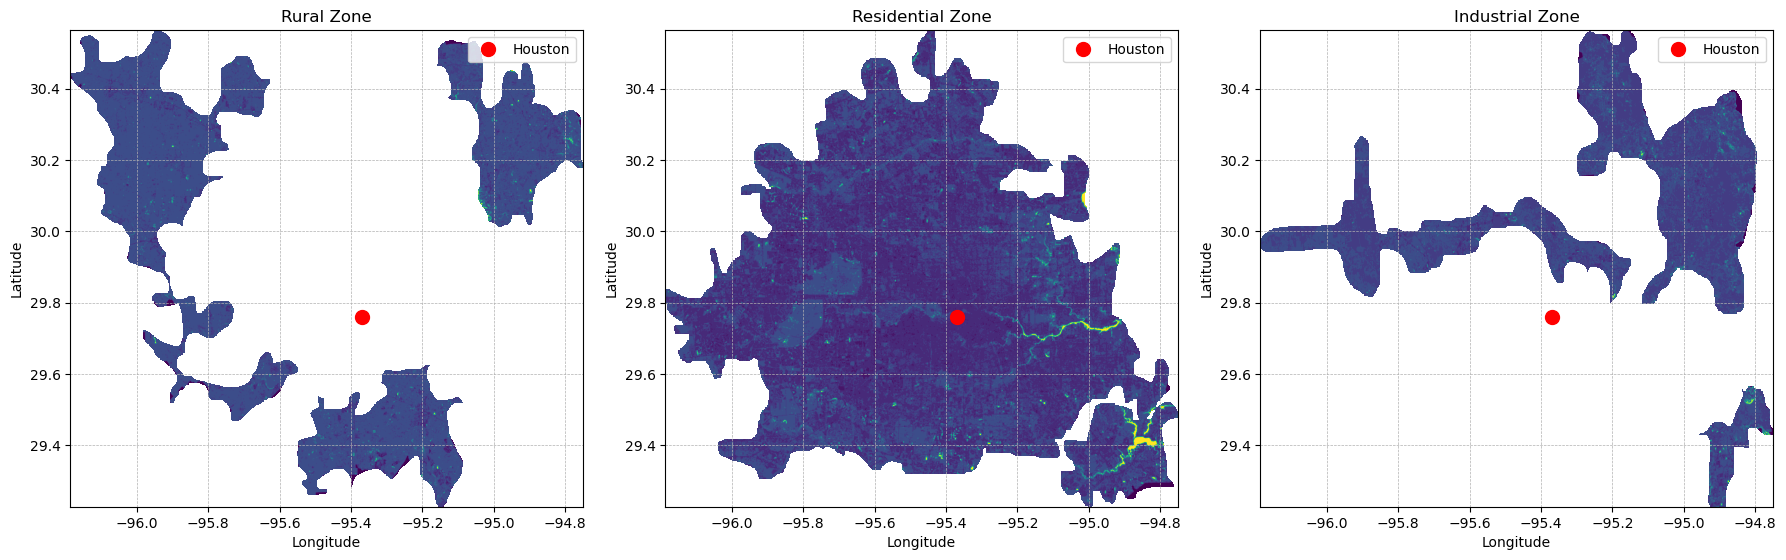

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

# File paths for different zones
file_paths = {
    'rural': '../data/rasters/rural.tif',
    'residential': '../data/rasters/residential.tif',
    'industrial': '../data/rasters/industry.tif'
}

# Houston coordinates in WGS 84 (latitude, longitude)
houston_coordinates_wgs84 = (29.7604, -95.3698)

# Variables to store the overall maximum and minimum coordinates
overall_left = float('inf')
overall_right = float('-inf')
overall_bottom = float('inf')
overall_top = float('-inf')

# Iterate through file paths to find the overall maximum and minimum coordinates
for file_path in file_paths.values():
    with rasterio.open(file_path) as src:
        left, bottom, right, top = src.bounds
        overall_left = min(overall_left, left)
        overall_right = max(overall_right, right)
        overall_bottom = min(overall_bottom, bottom)
        overall_top = max(overall_top, top)

# Create a 1x3 grid of plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Titles for each zone
zone_titles = ['Rural Zone', 'Residential Zone', 'Industrial Zone']

# Define a resampling factor to reduce the size of the images
resampling_factor = 0.25

# Iterate through the axes and file paths to plot each image with the same axes
for ax, (zone, file_path), title in zip(axes, file_paths.items(), zone_titles):
    with rasterio.open(file_path) as src:
        # Calculate new shape based on resampling factor
        new_shape = (int(src.height * resampling_factor), int(src.width * resampling_factor))

        # Read and resample the data into an array, then convert to float
        image = src.read(1, out_shape=new_shape, resampling=Resampling.bilinear).astype(float)

        # Mask out the no-data values by setting them to NaN
        image[image == src.nodatavals[0]] = np.nan

        # Display the image with a specific color map and color limits
        ax.imshow(image, cmap='viridis', vmin=np.nanmin(image), vmax=np.nanmax(image),
                  extent=[overall_left, overall_right, overall_bottom, overall_top])

        # Plot the Houston coordinates as a red dot and add legend
        ax.plot(houston_coordinates_wgs84[1], houston_coordinates_wgs84[0], 'ro', markersize=10, label='Houston')
        ax.legend()

        ax.set_title(title)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Add top and right bounding box
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

plt.tight_layout()
plt.show()


In [2]:
import rasterio
import numpy as np

# Open the geotiff file
with rasterio.open('../data/rasters/rural.tif') as src:
    # Read the image data into a 2D numpy array
    image = src.read(1)
    # Get the transformation matrix of the image
    transform = src.transform

# Get the indices of the pixels that are not 0 (0 typically represents no data)
rows, cols = np.where(image != 0)

# Convert the indices to coordinates using vectorized operations
x_coords, y_coords = transform * (cols, rows)

# Combine the coordinates into tuples
coordinates_vectorized = list(zip(x_coords, y_coords))

# Displaying the first 10 coordinates
coordinates_vectorized[:10]
len(coordinates_vectorized)

18673052

In [3]:
import pandas as pd
from scipy.spatial import cKDTree

# Load the cell_area_1.csv file into a DataFrame
core_area_pd_path = '../data/core_area_1.csv'
core_area_pd = pd.read_csv(core_area_pd_path)

# Convert the filtered_coordinates list into a DataFrame
filtered_coords_df = pd.DataFrame(coordinates_vectorized, columns=['Longitude', 'Latitude'])

# Create KDTree for core_area_pd to perform nearest-neighbor search
tree = cKDTree(core_area_pd[['Longitude', 'Latitude']].values)

# Find the index of the nearest neighbor in core_area_pd for each point in filtered_coords_df
distances, idx = tree.query(filtered_coords_df[['Longitude', 'Latitude']].values)

# Filter the core_area_pd DataFrame based on the nearest-neighbor indices
filtered_core_area_nearest = core_area_pd.iloc[idx].drop_duplicates().reset_index(drop=True)

filtered_core_area_nearest.head()  # Displaying the first few rows of the filtered core area for inspection


,Longitude,Latitude,core_area
0,-96.187060,30.220263,17.25
1,-96.183590,30.219213,20.25
2,-96.182500,30.221186,16.25
3,-96.173080,30.215937,6.50
4,-96.162834,30.216492,39.25


# Plot of the core_area for each zone

In [24]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from rasterio.enums import Resampling
from rasterio.transform import from_origin

# Load core area data from CSV file
core_area_pd_path = '../data/core_area_1.csv'
core_area_data= pd.read_csv(core_area_pd_path)

# Create a new GeoTIFF file for the core area using rasterio
core_area_tif = 'core_area.tif'
resolution = 0.01  # Adjust this value based on the desired resolution
width = int(np.ceil((core_area_data['Longitude'].max() - core_area_data['Longitude'].min()) / resolution)) + 1
height = int(np.ceil((core_area_data['Latitude'].max() - core_area_data['Latitude'].min()) / resolution)) + 1
transform = from_origin(core_area_data['Longitude'].min(), core_area_data['Latitude'].max(), resolution, resolution)

with rasterio.open(core_area_tif, 'w', driver='GTiff', height=height, width=width, count=1, dtype=np.float32, crs='+proj=latlong', transform=transform) as dst:
    for index, data_row in core_area_data.iterrows():
        col = int((data_row['Longitude'] - core_area_data['Longitude'].min()) / resolution)
        row_index = int((core_area_data['Latitude'].max() - data_row['Latitude']) / resolution)
        dst.write(np.array([[data_row['core_area']]]), indexes=1, window=((row_index, row_index + 1), (col, col + 1)))

# Update file paths for different zones
file_paths = {
    'rural': '../data/rasters/rural.tif',
    'residential': '../data/rasters/residential.tif',
    'industrial': '../data/rasters/industry.tif',
    'core_area': core_area_tif
}

# Houston coordinates in WGS 84 (latitude, longitude)
houston_coordinates_wgs84 = (29.7604, -95.3698)

# Variables to store the overall maximum and minimum coordinates
overall_left = float('inf')
overall_right = float('-inf')
overall_bottom = float('inf')
overall_top = float('-inf')

# Iterate through file paths to find the overall maximum and minimum coordinates
for file_path in file_paths.values():
    with rasterio.open(file_path) as src:
        left, bottom, right, top = src.bounds
        overall_left = min(overall_left, left)
        overall_right = max(overall_right, right)
        overall_bottom = min(overall_bottom, bottom)
        overall_top = max(overall_top, top)

# Update titles for each zone
zone_titles = ['Rural Zone', 'Residential Zone', 'Industrial Zone', 'Core Area']

# Define a resampling factor to reduce the size of the images
resampling_factor = 0.25

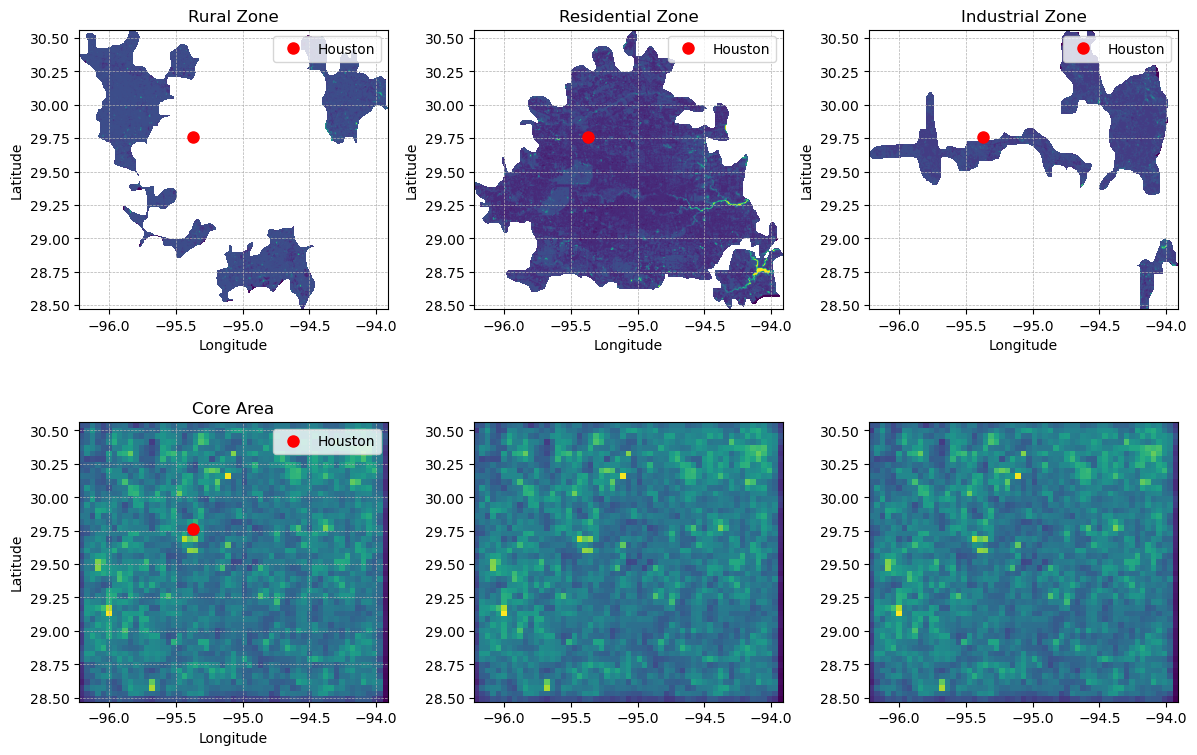

In [31]:


# Create a 2x3 grid of plots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Iterate through the axes and file paths to plot each image with the same axes
for i, (zone, file_path), title in zip(range(6), file_paths.items(), zone_titles):
    with rasterio.open(file_path) as src:
        # Calculate new shape based on resampling factor
        new_shape = (int(src.height * resampling_factor), int(src.width * resampling_factor))

        # Read and resample the data into an array, then convert to float
        image = src.read(1, out_shape=new_shape, resampling=Resampling.bilinear).astype(float)

        # Mask out the no-data values by setting them to NaN
        image[image == src.nodatavals[0]] = np.nan

        # Display the image with a specific color map and color limits
        row = i // 3  # Calculate the row index
        col = i % 3  # Calculate the column index

        if row == 1:  # Check if it's the second row
            # Plot the core area for all three columns
            axes[row, 0].imshow(image, cmap='viridis', vmin=np.nanmin(image), vmax=np.nanmax(image),
                                extent=[overall_left, overall_right, overall_bottom, overall_top])
            axes[row, 1].imshow(image, cmap='viridis', vmin=np.nanmin(image), vmax=np.nanmax(image),
                                extent=[overall_left, overall_right, overall_bottom, overall_top])
            axes[row, 2].imshow(image, cmap='viridis', vmin=np.nanmin(image), vmax=np.nanmax(image),
                                extent=[overall_left, overall_right, overall_bottom, overall_top])
        else:
            # Plot the other zones
            axes[row, col].imshow(image, cmap='viridis', vmin=np.nanmin(image), vmax=np.nanmax(image),
                                  extent=[overall_left, overall_right, overall_bottom, overall_top])

        # Plot the Houston coordinates as a red dot and add legend
        axes[row, col].plot(houston_coordinates_wgs84[1], houston_coordinates_wgs84[0], 'ro', markersize=8, label='Houston')
        axes[row, col].legend()

        axes[row, col].set_title(title)
        axes[row, col].set_xlabel('Longitude')
        axes[row, col].set_ylabel('Latitude')
        axes[row, col].grid(True, which='both', linestyle='--', linewidth=0.5)

        # Add top and right bounding box
        axes[row, col].spines['top'].set_visible(True)
        axes[row, col].spines['right'].set_visible(True)


plt.tight_layout()
plt.show()